In [180]:
#Import Libraries
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from highlight_text import ax_text

from mplsoccer import Pitch, VerticalPitch, add_image, FontManager, Sbopen

# Pass Maps



In [164]:
parser = Sbopen()
events, related, freeze, tactics = parser.event(3795506)
lineup = parser.lineup(3795506)

In [165]:
lineup

,player_id,player_name,player_nickname,jersey_number,match_id,team_id,team_name,country_id,country_name
0,3166,Marco Verratti,Marco Verratti,6,3795506,914,Italy,112,Italy
1,4355,Emerson Palmieri dos Santos,Emerson,13,3795506,914,Italy,112,Italy
2,6954,Giorgio Chiellini,Giorgio Chiellini,3,3795506,914,Italy,112,Italy
3,6957,Alex Meret,Alex Meret,26,3795506,914,Italy,112,Italy
4,6964,Alessandro Florenzi,Alessandro Florenzi,24,3795506,914,Italy,112,Italy
5,6993,Bryan Cristante,Bryan Cristante,16,3795506,914,Italy,112,Italy
6,7002,Rafael Tolói,Rafael Tolói,25,3795506,914,Italy,112,Italy
7,7024,Jorge Luiz Frello Filho,Jorginho,8,3795506,914,Italy,112,Italy
8,7036,Gianluigi Donnarumma,Gianluigi Donnarumma,21,3795506,914,Italy,112,Italy
9,7037,Lorenzo Insigne,Lorenzo Insigne,10,3795506,914,Italy,112,Italy


Add on the subbed on/ off times to the lineup dataframe



In [166]:
# dataframe with player_id and when they were subbed off
time_off = events.loc[(events.type_name == 'Substitution'),
                      ['player_id', 'minute']]
time_off.rename({'minute': 'off'}, axis='columns', inplace=True)

# dataframe with player_id and when they were subbed on
time_on = events.loc[(events.type_name == 'Substitution'),
                     ['substitution_replacement_id', 'minute']]
time_on.rename({'substitution_replacement_id': 'player_id',
                'minute': 'on'}, axis='columns', inplace=True)
players_on = time_on.player_id

# merge on times subbed on/off
lineup = lineup.merge(time_on, on='player_id', how='left')
lineup = lineup.merge(time_off, on='player_id', how='left')

Filter the lineup to include players who played and add on the first position they played



In [167]:
# filter the tactics lineup for the starting xi
starting_ids = events[events.type_name == 'Starting XI'].id
starting_xi = tactics[tactics.id.isin(starting_ids)]
starting_players = starting_xi.player_id

# filter the lineup for players that actually played
mask_played = ((lineup.on.notnull()) | (lineup.off.notnull()) |
               (lineup.player_id.isin(starting_players)))
lineup = lineup[mask_played].copy()

# get the first position for each player and add this to the lineup dataframe
player_positions = (events[['player_id', 'position_id']]
                    .dropna(how='any', axis='rows')
                    .drop_duplicates('player_id', keep='first'))
lineup = lineup.merge(player_positions, how='left', on='player_id')

# add on the position abbreviation
formation_dict = {1: 'GK', 2: 'RB', 3: 'RCB', 4: 'CB', 5: 'LCB', 6: 'LB', 7: 'RWB',
                  8: 'LWB', 9: 'RDM', 10: 'CDM', 11: 'LDM', 12: 'RM', 13: 'RCM',
                  14: 'CM', 15: 'LCM', 16: 'LM', 17: 'RW', 18: 'RAM', 19: 'CAM',
                  20: 'LAM', 21: 'LW', 22: 'RCF', 23: 'ST', 24: 'LCF', 25: 'SS'}
lineup['position_abbreviation'] = lineup.position_id.map(formation_dict)

# sort the dataframe so the players are
# in the order of their position (if started), otherwise in the order they came on
lineup['start'] = lineup.player_id.isin(starting_players)
lineup.sort_values(['team_name', 'start', 'on', 'position_id'],
                   ascending=[True, False, True, True], inplace=True)

Filter the lineup/ events to one team and exclude some set pieces



In [168]:
team1, team2 = lineup.team_name.unique()  # England (team1), Italy(team2)
lineup_team1 = lineup[lineup.team_name == team1].copy()

# filter the events to exclude some set pieces
set_pieces = ['Throw-in', 'Free Kick', 'Corner', 'Kick Off', 'Goal Kick']

# for the player pass maps
passes_excl_throw1 = events[(events.team_name == team1) & (events.type_name == 'Pass') &
                           (events.sub_type_name != 'Throw-in')].copy()

# identify how many players played and how many subs were used
# we will use this in the loop for only plotting pass maps for as
# many players who played
num_players1 = len(lineup_team1)
num_sub1 = num_players1 - 11

In [169]:
lineup_team2 = lineup[lineup.team_name == team2].copy()

# for the player pass maps
passes_excl_throw2 = events[(events.team_name == team2) & (events.type_name == 'Pass') &
                           (events.sub_type_name != 'Throw-in')].copy()

# identify how many players played and how many subs were used
# we will use this in the loop for only plotting pass maps for as
# many players who played
num_players2 = len(lineup_team2)
num_sub2 = num_players2 - 11

Setup the pitch, arrows, and get some images



In [170]:
# add padding to the top so we can plot the titles, and raise the pitch lines
pitch = Pitch(pad_top=10, line_zorder=2)

# arrow properties for the sub on/off
green_arrow = dict(arrowstyle='simple, head_width=0.7',
                   connectionstyle="arc3,rad=-0.8", fc="green", ec="green")
red_arrow = dict(arrowstyle='simple, head_width=0.7',
                 connectionstyle="arc3,rad=-0.8", fc="red", ec="red")

# a fontmanager object for using a google font
fm_scada = FontManager('https://raw.githubusercontent.com/googlefonts/scada/main/fonts/ttf/'
                       'Scada-Regular.ttf')


Plotting the Pass Maps



Text(0.5, 0.35, 'Player Pass Maps: exclude throw-ins only')

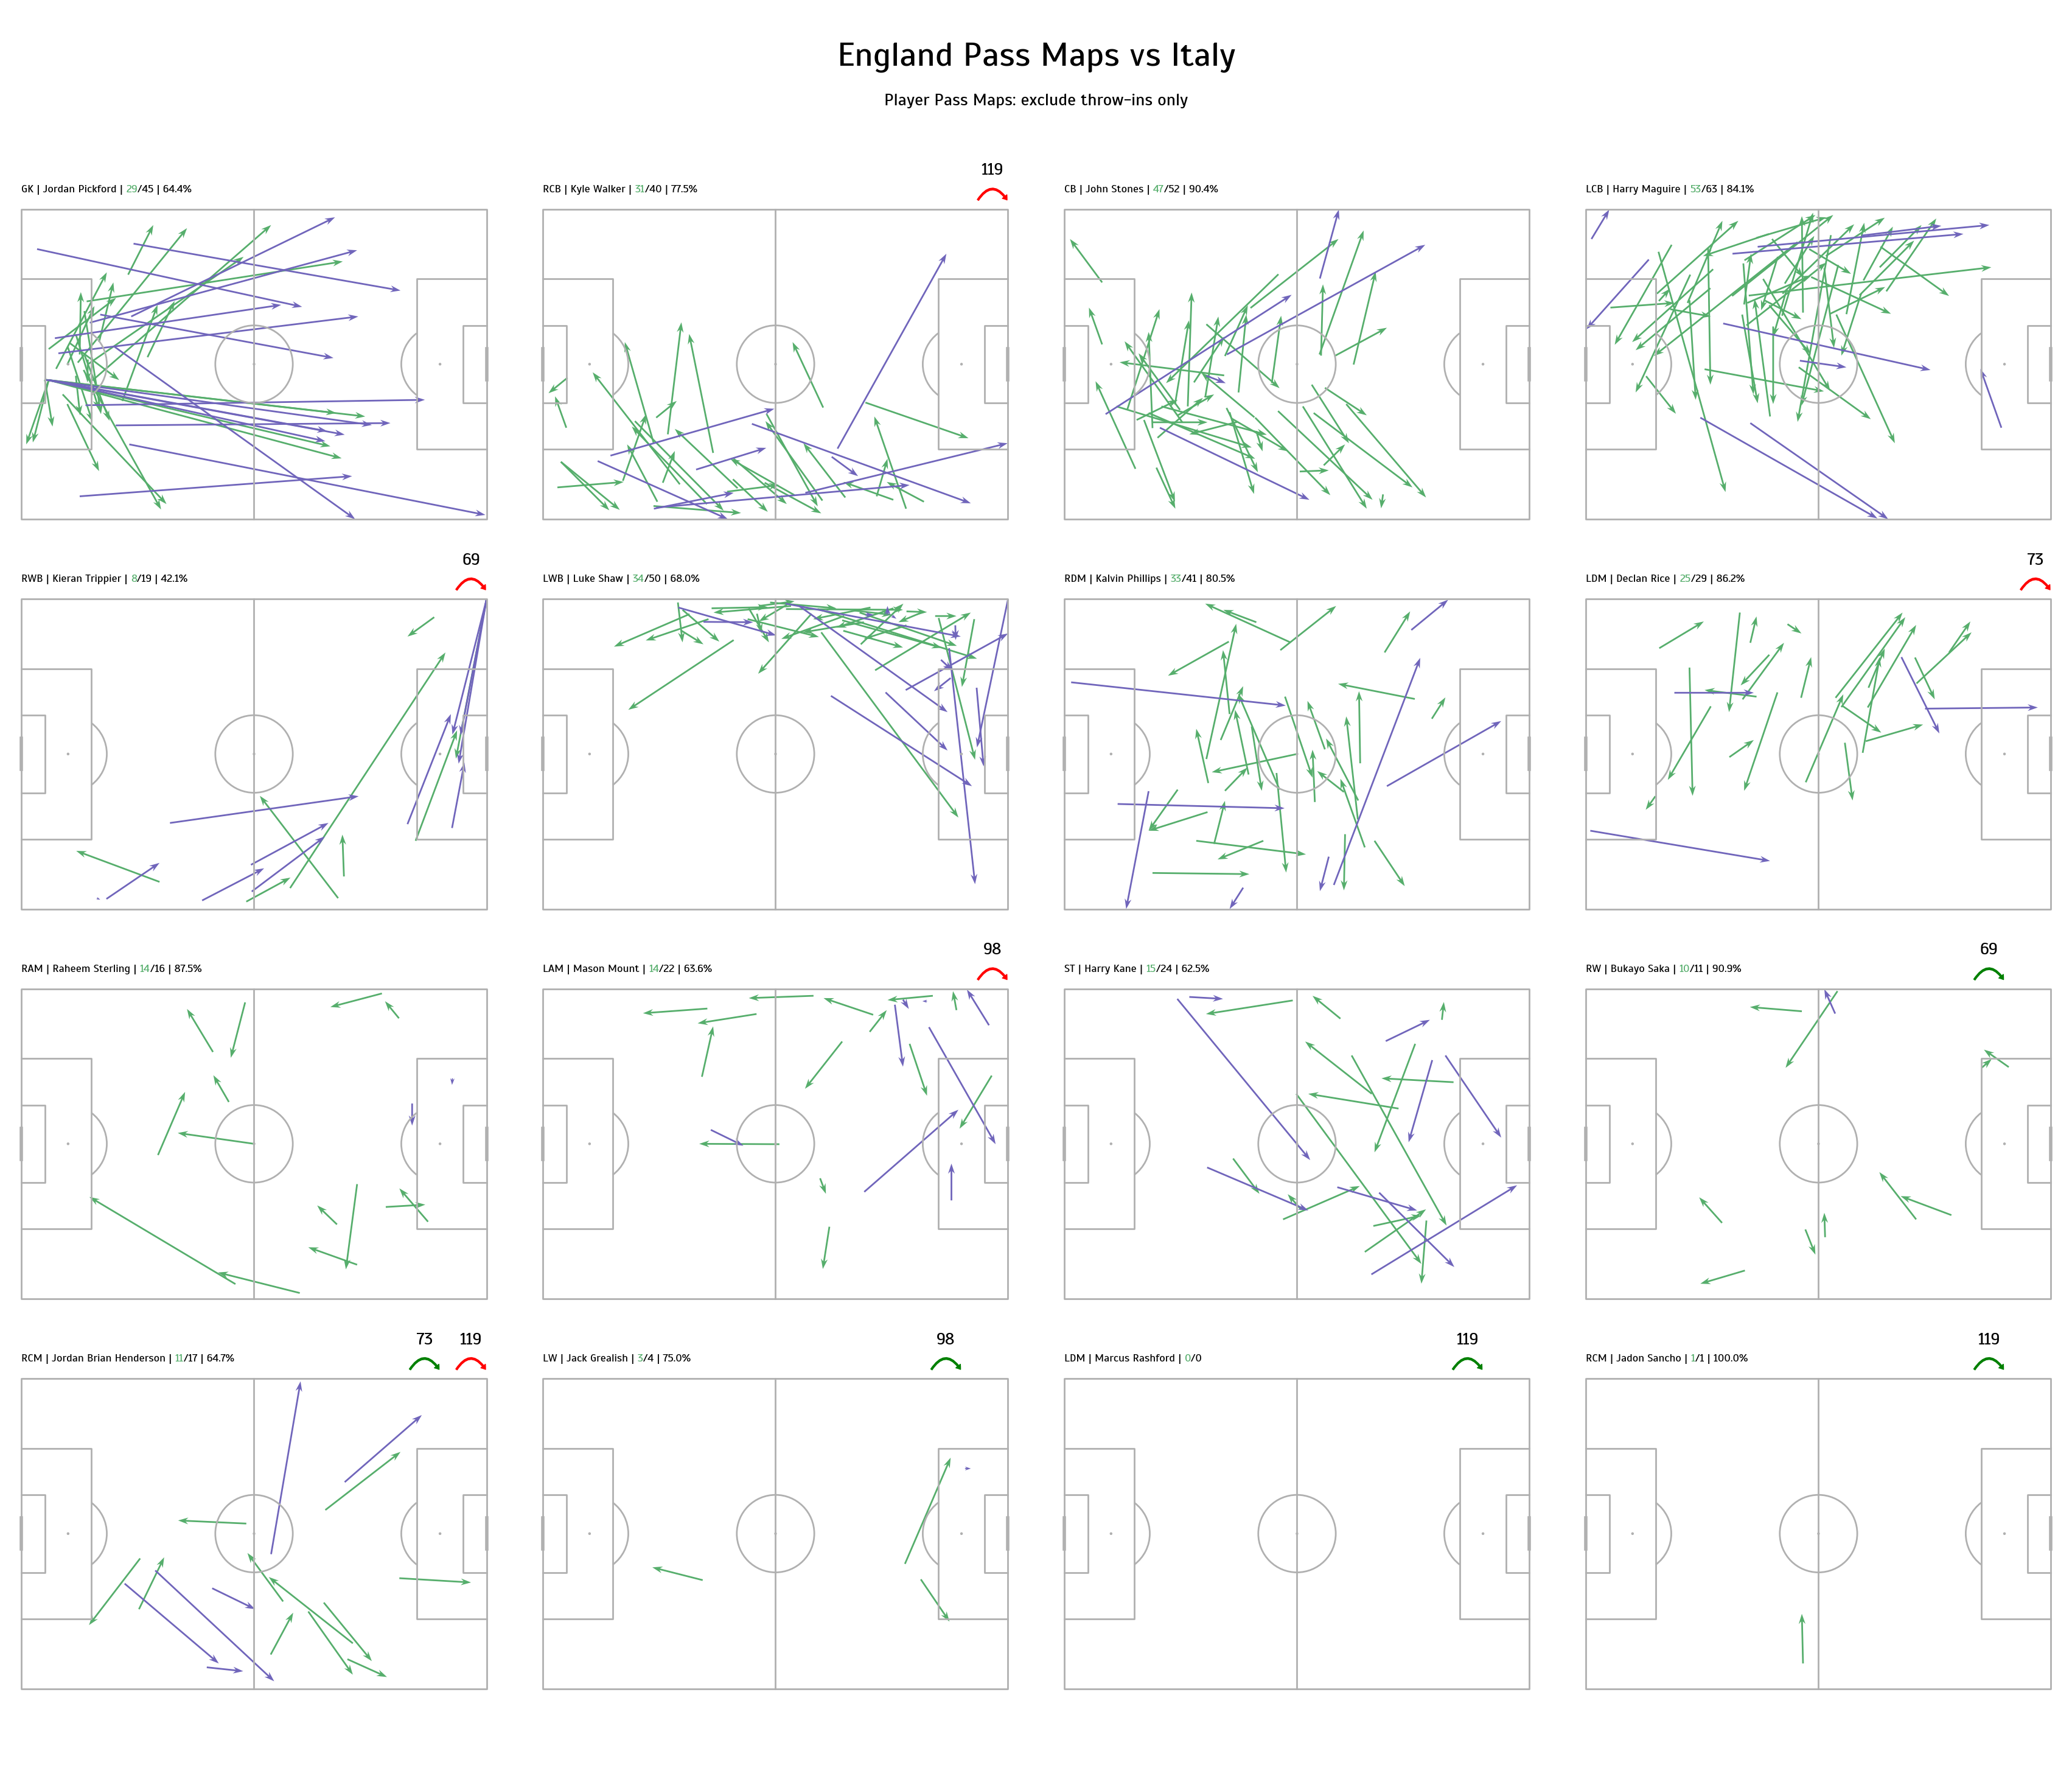

In [171]:

warnings.simplefilter("ignore", UserWarning)

# plot the 4 * 4 grid
fig, axs = pitch.grid(nrows=4, ncols=4, figheight=30,
                      endnote_height=0.03, endnote_space=0,
                      # Turn off the endnote/title axis. I usually do this after
                      # I am happy with the chart layout and text placement
                      axis=False,
                      title_height=0.08, grid_height=0.84)
# cycle through the grid axes and plot the player pass maps
for idx, ax in enumerate(axs['pitch'].flat):
    # only plot the pass maps up to the total number of players
    if idx < num_players:
        # filter the complete/incomplete passes for each player (excudes throw-ins)
        lineup_player = lineup_team1.iloc[idx]
        player_id = lineup_player.player_id
        player_pass = passes_excl_throw[passes_excl_throw.player_id == player_id]
        complete_pass = player_pass[player_pass.outcome_name.isnull()]
        incomplete_pass = player_pass[player_pass.outcome_name.notnull()]

        # plot the arrows
        pitch.arrows(complete_pass.x, complete_pass.y,
                     complete_pass.end_x, complete_pass.end_y,
                     color='#56ae6c', width=2, headwidth=4, headlength=6, ax=ax)
        pitch.arrows(incomplete_pass.x, incomplete_pass.y,
                     incomplete_pass.end_x, incomplete_pass.end_y,
                     color='#7065bb', width=2, headwidth=4, headlength=6, ax=ax)


        total_pass = len(complete_pass) + len(incomplete_pass)
        if (total_pass != 0):
            annotation_string = (f'{lineup_player.position_abbreviation} | '
                                 f'{lineup_player.player_name} | '
                                 f'<{len(complete_pass)}>/{total_pass} | '
                                 f'{round(100 * len(complete_pass)/(total_pass), 1)}%')
        else:
            annotation_string = (f'{lineup_player.position_abbreviation} | '
                                 f'{lineup_player.player_name} | '
                                 f'<{len(complete_pass)}>/{total_pass}')
        ax_text(0, -5, annotation_string, ha='left', va='center', fontsize=13,
                fontproperties=fm_scada.prop,  # using the fontmanager for the google font
                highlight_textprops=[{"color": '#56ae6c'}], ax=ax)

        # add information for subsitutions on/off and arrows
        if not np.isnan(lineup_team.iloc[idx].off):
            ax.text(116, -10, str(lineup_team.iloc[idx].off.astype(int)), fontsize=20,
                    fontproperties=fm_scada.prop,
                    ha='center', va='center')
            ax.annotate('', (120, -2), (112, -2), arrowprops=red_arrow)
        if not np.isnan(lineup_team.iloc[idx].on):
            ax.text(104, -10, str(lineup_team.iloc[idx].on.astype(int)), fontsize=20,
                    fontproperties=fm_scada.prop,
                    ha='center', va='center')
            ax.annotate('', (108, -2), (100, -2), arrowprops=green_arrow)


# remove unused axes (if any)
for ax in axs['pitch'].flat[11 + num_sub:]:
    ax.remove()


# title text
axs['title'].text(0.5, 0.65, f'{team1} Pass Maps vs {team2}', fontsize=40,
                  fontproperties=fm_scada.prop, va='center', ha='center')
SUB_TEXT = ('Player Pass Maps: exclude throw-ins only')
axs['title'].text(0.5, 0.35, SUB_TEXT, fontsize=20,
                  fontproperties=fm_scada.prop, va='center', ha='center')


Text(0.5, 0.35, 'Player Pass Maps: exclude throw-ins only')

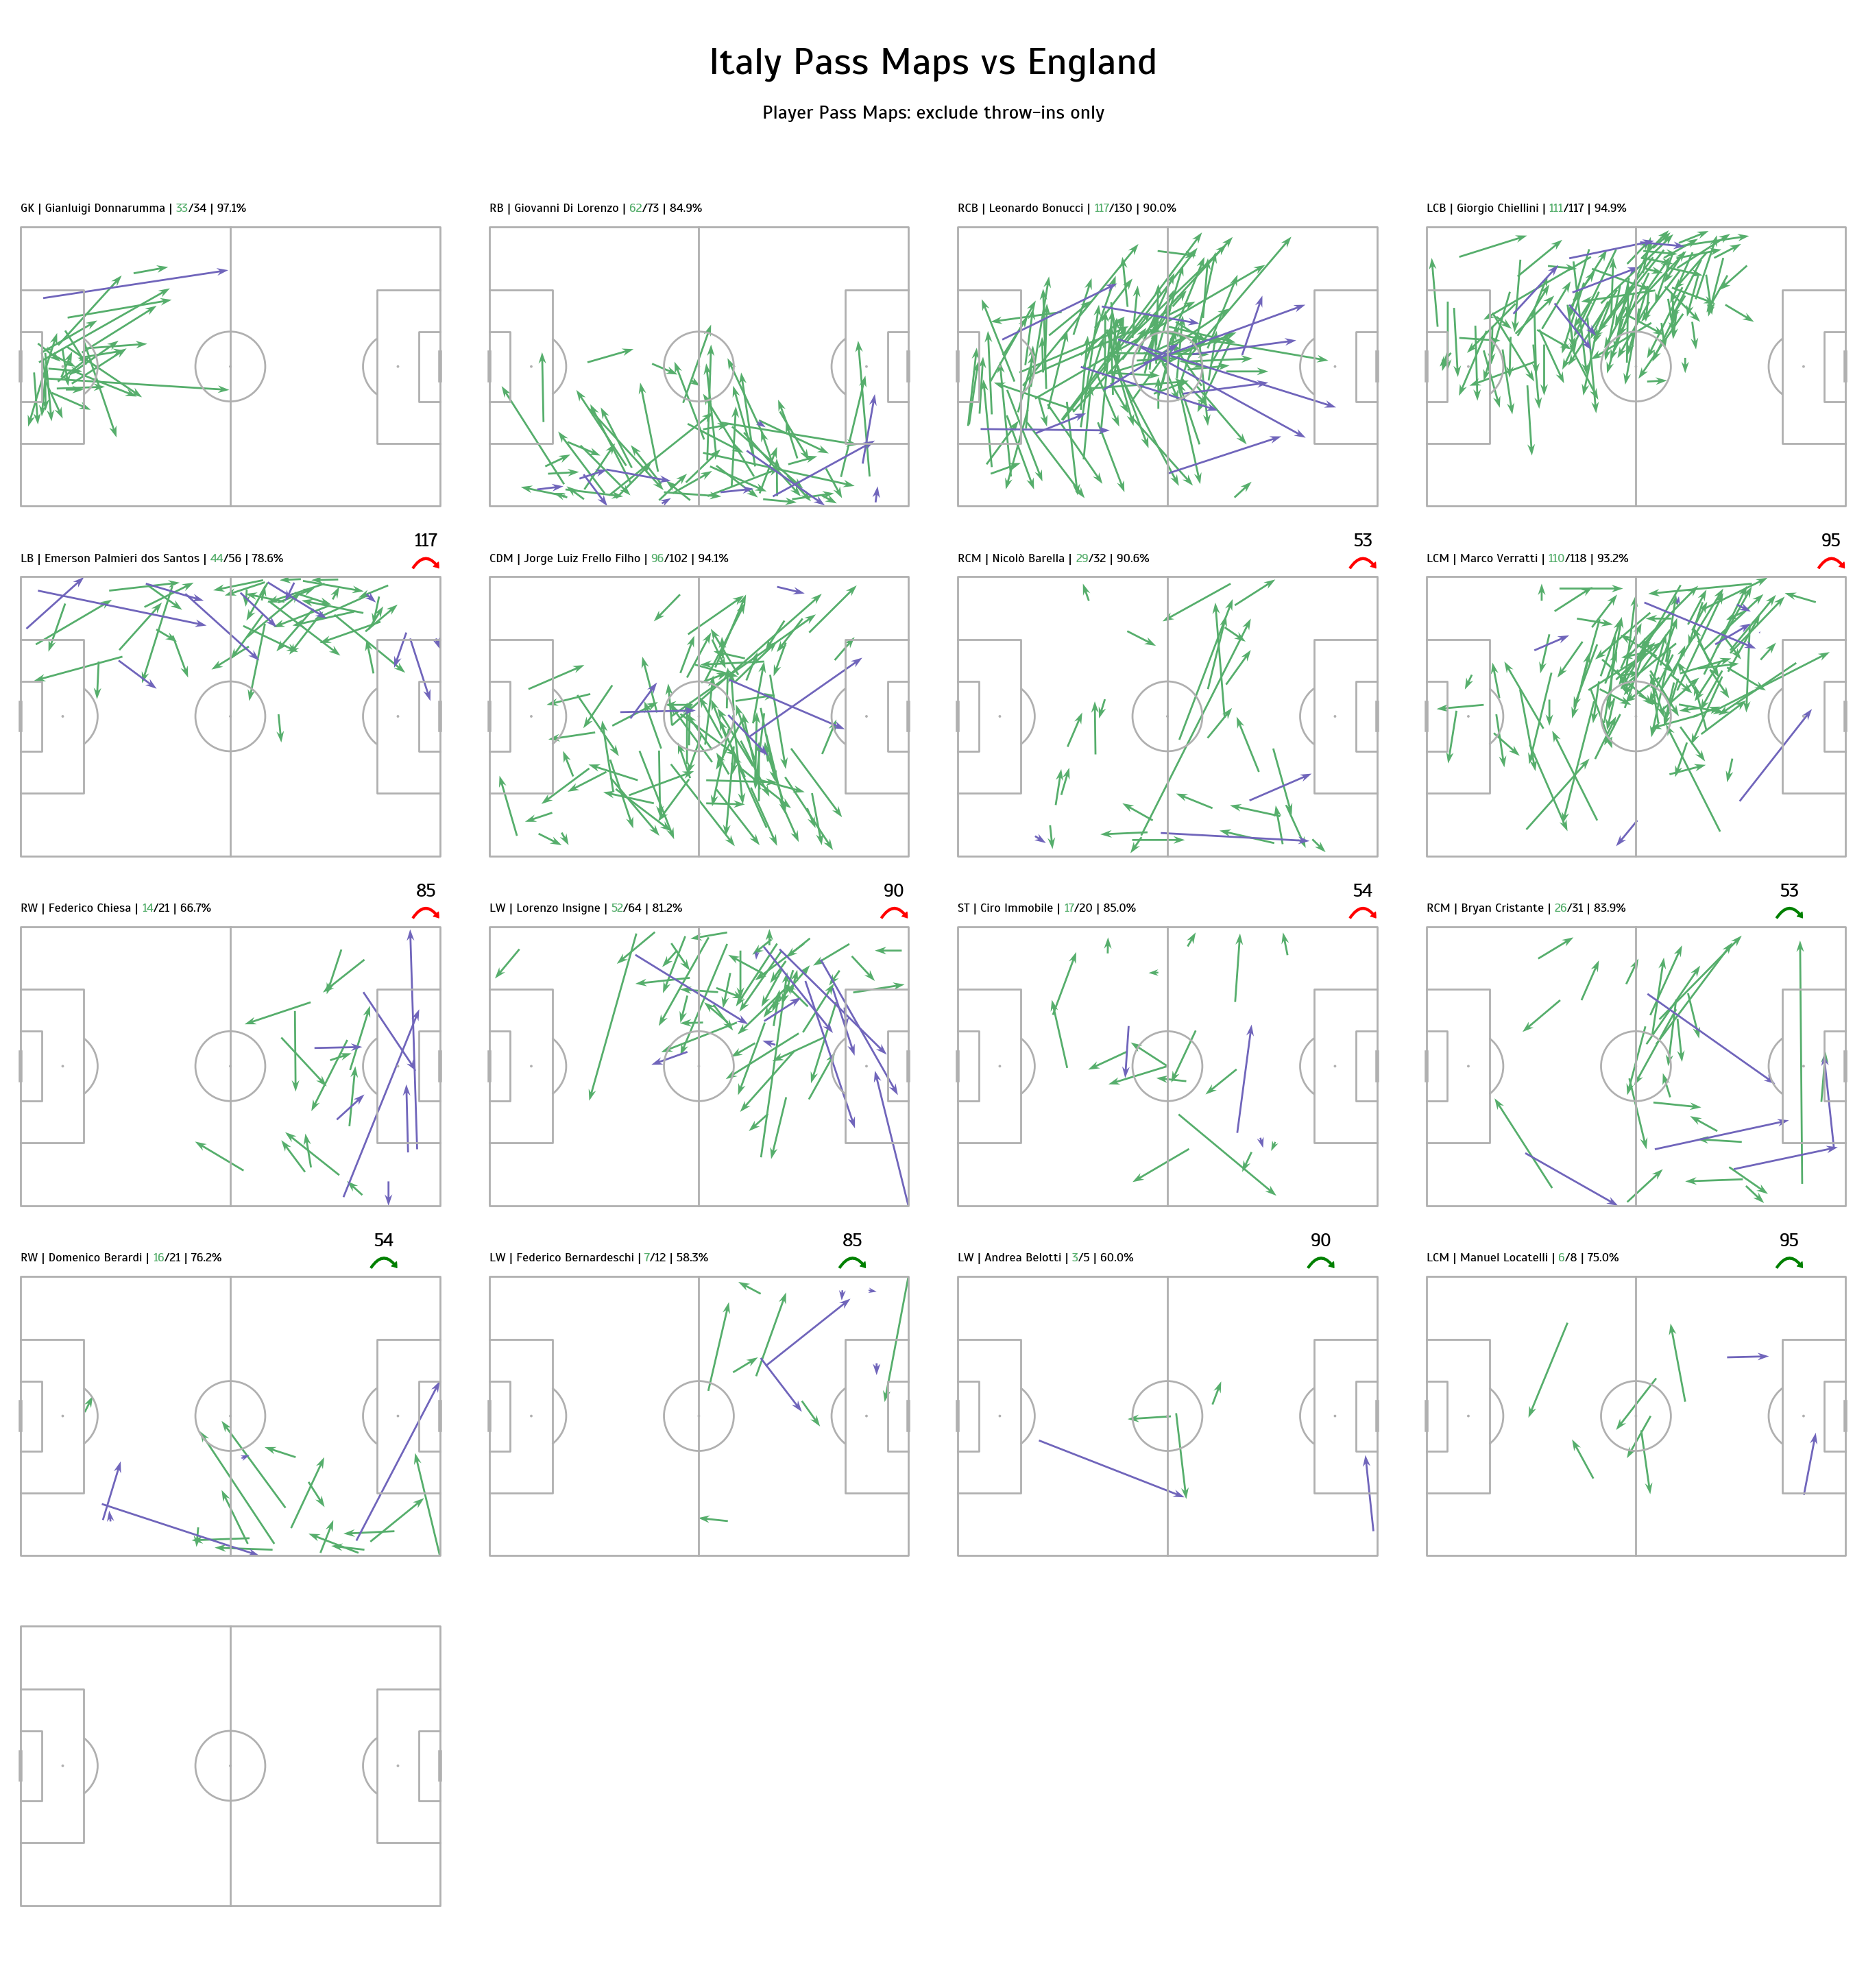

In [172]:
warnings.simplefilter("ignore", UserWarning)

# plot the 5 * 4 grid
fig, axs = pitch.grid(nrows=5, ncols=4, figheight=30,
                      endnote_height=0.03, endnote_space=0,
                      axis=False,
                      title_height=0.08, grid_height=0.84)

# cycle through the grid axes and plot the player pass maps
for idx, ax in enumerate(axs['pitch'].flat):
    if idx < num_players:
        # filter the complete/incomplete passes for each player (excudes throw-ins)
        lineup_player = lineup_team2.iloc[idx]
        player_id = lineup_player.player_id
        player_pass = passes_excl_throw2[passes_excl_throw2.player_id == player_id]
        complete_pass = player_pass[player_pass.outcome_name.isnull()]
        incomplete_pass = player_pass[player_pass.outcome_name.notnull()]

        # plot the arrows
        pitch.arrows(complete_pass.x, complete_pass.y,
                     complete_pass.end_x, complete_pass.end_y,
                     color='#56ae6c', width=2, headwidth=4, headlength=6, ax=ax)
        pitch.arrows(incomplete_pass.x, incomplete_pass.y,
                     incomplete_pass.end_x, incomplete_pass.end_y,
                     color='#7065bb', width=2, headwidth=4, headlength=6, ax=ax)


        total_pass = len(complete_pass) + len(incomplete_pass)
        if (total_pass != 0):
            annotation_string = (f'{lineup_player.position_abbreviation} | '
                                 f'{lineup_player.player_name} | '
                                 f'<{len(complete_pass)}>/{total_pass} | '
                                 f'{round(100 * len(complete_pass)/(total_pass), 1)}%')
        else:
            annotation_string = (f'{lineup_player.position_abbreviation} | '
                                 f'{lineup_player.player_name} | '
                                 f'<{len(complete_pass)}>/{total_pass}')
        ax_text(0, -5, annotation_string, ha='left', va='center', fontsize=13,
                fontproperties=fm_scada.prop,  # using the fontmanager for the google font
                highlight_textprops=[{"color": '#56ae6c'}], ax=ax)

        # add information for subsitutions on/off and arrows
        if not np.isnan(lineup_team2.iloc[idx].off):
            ax.text(116, -10, str(lineup_team2.iloc[idx].off.astype(int)), fontsize=20,
                    fontproperties=fm_scada.prop,
                    ha='center', va='center')
            ax.annotate('', (120, -2), (112, -2), arrowprops=red_arrow)
        if not np.isnan(lineup_team2.iloc[idx].on):
            ax.text(104, -10, str(lineup_team2.iloc[idx].on.astype(int)), fontsize=20,
                    fontproperties=fm_scada.prop,
                    ha='center', va='center')
            ax.annotate('', (108, -2), (100, -2), arrowprops=green_arrow)


# remove unused axes (if any)
for ax in axs['pitch'].flat[11 + num_sub2:]:
    ax.remove()


# title text
axs['title'].text(0.5, 0.65, f'{team2} Pass Maps vs {team1}', fontsize=40,
                  fontproperties=fm_scada.prop, va='center', ha='center')
SUB_TEXT = ('Player Pass Maps: exclude throw-ins only')
axs['title'].text(0.5, 0.35, SUB_TEXT, fontsize=20,
                  fontproperties=fm_scada.prop, va='center', ha='center')


# Shot & xG Analysis

In [173]:
shots = events[events['type_name'] == 'Shot']
pen = shots[shots['sub_type_name'] == 'Penalty']

In [174]:
pen = pen[['team_name', 'player_name','minute','sub_type_name','outcome_name']]
pen

,team_name,player_name,minute,sub_type_name,outcome_name
4774,Italy,Domenico Berardi,120,Penalty,Goal
4776,England,Harry Kane,120,Penalty,Goal
4778,Italy,Andrea Belotti,121,Penalty,Saved
4780,England,Harry Maguire,122,Penalty,Goal
4782,Italy,Leonardo Bonucci,123,Penalty,Goal
4784,England,Marcus Rashford,124,Penalty,Post
4786,Italy,Federico Bernardeschi,125,Penalty,Goal
4788,England,Jadon Sancho,125,Penalty,Saved
4790,Italy,Jorge Luiz Frello Filho,126,Penalty,Saved to Post
4792,England,Bukayo Saka,127,Penalty,Saved


In [175]:
#Final Score after Penalty Shootout
pen[['team_name','outcome_name']].groupby('team_name').value_counts()

team_name  outcome_name 
England    Goal             2
           Saved            2
           Post             1
Italy      Goal             3
           Saved            1
           Saved to Post    1
dtype: int64

In [176]:
#Separate Italy Shots & England Shots
shots_italy = shots[(shots['sub_type_name'] != 'Penalty') &
              (shots['team_name'] == 'Italy')]
shots_england = shots[(shots['sub_type_name'] != 'Penalty') &
                (shots['team_name'] == 'England')]

In [177]:
#Seperate Non-Goal vs Goal shots for each team
non_goal_italy = shots_italy[shots_italy['outcome_name'] != "Goal"]
goal_italy = shots_italy[shots_italy['outcome_name'] == "Goal"]
non_goal_england = shots_england[shots_england['outcome_name'] != "Goal"]
goal_england = shots_england[shots_england['outcome_name'] == "Goal"]

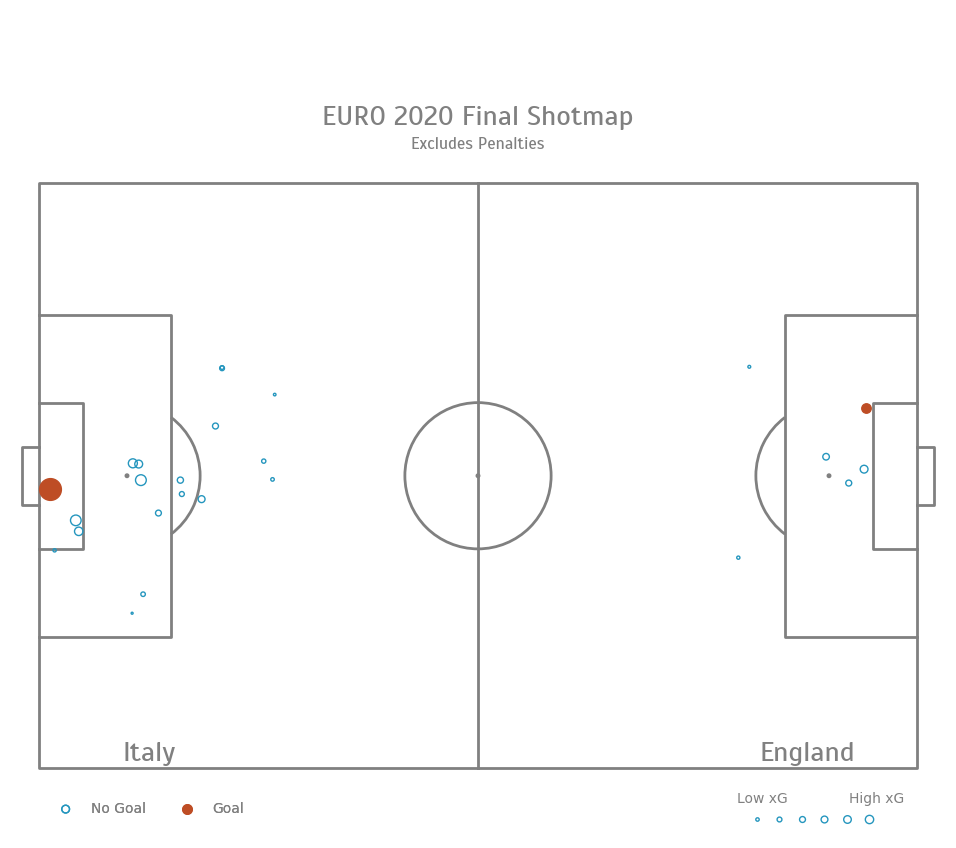

In [178]:
# Plot a Jointgrid
pitch2  = Pitch(pitch_color = 'white', line_color='grey', goal_type = "box")
fig, axs = pitch2.grid(axis= False,endnote_space=-0.02)


#Invert Italy Coords
non_goal_italy_x_new = pitch2.dim.right - non_goal_italy['x']
non_goal_italy_y_new  = pitch2.dim.bottom - non_goal_italy['y'] 
goal_italy_x_new = pitch2.dim.right - goal_italy['x']
goal_italy_y_new = pitch2.dim.bottom - goal_italy['y'] 

#PLot Italy Shots
italy_ng_shots = pitch2.scatter(non_goal_italy_x_new, non_goal_italy_y_new, s=non_goal_shots_italy['shot_statsbomb_xg'] * 300,
                               color='#2596be',facecolors='none', ax=axs['pitch'])
italy_g_shots = pitch2.scatter(goal_italy_x_new, goal_italy_y_new, s=goal_shots_italy['shot_statsbomb_xg'] * 300,
                               color='#be4d25', ax=axs['pitch'])
#Plot England Shots
england_ng_shots = pitch2.scatter(non_goal_england['x'], non_goal_england['y'], s=non_goal_shots_england['shot_statsbomb_xg'] * 300,
                               color='#2596be',facecolors='none', ax=axs['pitch'])
england_g_shots = pitch2.scatter(goal_england['x'], goal_england['y'], s=goal_shots_england['shot_statsbomb_xg'] * 300,
                               color='#be4d25', ax=axs['pitch'])

#Plot Text
txt_italy = axs['pitch'].text(x=15, y=78, s='Italy', fontproperties=fm_scada.prop, color='grey',
                         ha='center', va='center', fontsize=20)
txt_england = axs['pitch'].text(x=105, y=78, s='England', fontproperties=fm_scada.prop, color='grey',
                         ha='center', va='center', fontsize=20)
axs['title'].text(0.5, 0.2, "EURO 2020 Final Shotmap", color='grey',
                  fontproperties=fm_scada.prop, fontsize=20, ha='center', va='center')
SUB_TEXT = ('Excludes Penalties')
axs['title'].text(0.5, 0, SUB_TEXT, fontsize=12,color='grey',
                  fontproperties=fm_scada.prop, va='center', ha='center')

#Legends
handles, labels = italy_ng_shots.legend_elements(prop="sizes",color='#2596be',markerfacecolor='none')
labels = [' ', ' ', ' ', ' ', ' ', ' ']
legend1 = plt.legend(handles, labels,title ="Low xG              High xG", 
                                loc="upper right",frameon=False , ncol=6,columnspacing=-1.5)

legend2 = plt.legend((italy_ng_shots, england_g_shots),('No Goal', 'Goal'),loc='center left',ncol=2, frameon=False, labelcolor='grey')
axs['endnote'].add_artist(legend1)
axs['endnote'].add_artist(legend2)
legend1.get_title().set_color('grey') 

Text(0.5, 1.0, 'xG/Minute')

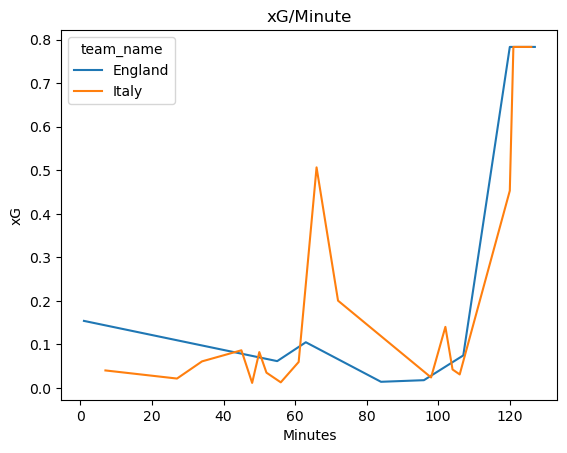

In [179]:
#Plot Lines to compare xG throughout the match
sns.lineplot(data=shots,x='minute',y='shot_statsbomb_xg',errorbar=None,hue = 'team_name')
plt.xlabel("Minutes")
plt.ylabel("xG")
plt.title("xG/Minute")